#### Errores y Mejoras: -Imputas la variable insulin que tiene más de un 50% de valores faltantes, intentarías demasiados datos con ello, recomendaría eliminarla si no justificas que se quede. -Falta VIF y Cross Validation. -No optimizas de ninguna manera tratando los hiperparámetros, te sugiero GridSearch o RandomSearch. -No comparas el resultado con random forest ni Decission Tree como se pide.

In [1]:
import pandas as pd
import numpy as np
import joblib
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from missforest import MissForest
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import lightgbm as lgb
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from scipy.stats import randint, uniform, zscore, stats
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv("/workspaces/carlossuesc95-intro-ml/data/raw/internal-link tree.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Eliminamos "Insulin" por tener demasiados valores faltantes 

In [3]:
#Susttuimos ceros por NaN
df.drop('Insulin', axis=1, inplace=True)
df_cop = df.copy()
vars_cero = ['BloodPressure', 'BMI', 'Glucose']
df_cop[vars_cero] = df_cop[vars_cero].replace(0, np.nan)

In [4]:
df_cop.isnull().sum()  

Pregnancies                  0
Glucose                      5
BloodPressure               35
SkinThickness                0
BMI                         11
DiabetesPedigreeFunction     0
Age                          0
Outcome                      0
dtype: int64

### Train Test Split

In [5]:
X = df_cop.drop('Outcome',axis=1)
y = df_cop['Outcome']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Imputación

In [7]:
imputer = MissForest()

X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)
X_train_imp

/home/vscode/.local/lib/python3.11/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:06<00:01,  1.42s/it]/home/vscode/.local/lib/python3.11/site-packages/missforest/missforest.py:303: UserWarning: NRMSE increased.
  warnings.warn("NRMSE increased.")
/home/vscode/.local/lib/python3.11/site-packages/missforest/missforest.py:453: UserWarning: Stopping criterion triggered during fitting. Before last imputation matrix will be returned.
  warnings.warn(
 80%|████████  | 4/5 [00:07<00:01,  1.79s/it]
/home/vscode/.local/lib/python3.11/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/home/vscode/.local/lib/python3.11/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old

,Pregnancies,SkinThickness,Age,DiabetesPedigreeFunction,Glucose,BMI,BloodPressure
60,2,0,21,0.304,84.0,27.053055,68.912462
618,9,24,50,1.282,112.0,28.200000,82.000000
346,1,19,22,0.654,139.0,28.700000,46.000000
294,0,0,65,0.254,161.0,21.900000,50.000000
231,6,37,46,0.238,134.0,46.200000,80.000000
...,...,...,...,...,...,...,...
71,5,35,26,0.411,139.0,28.600000,64.000000
106,1,0,27,0.207,96.0,22.400000,122.000000
270,10,37,38,1.136,101.0,45.600000,86.000000
435,0,0,29,0.205,141.0,42.400000,74.224111


## Sel Caracteristicas

In [8]:
# Modelo Random Forest
model = RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1).fit(X_train_imp,y_train)
# Importancia de características
importances = model.feature_importances_/model.feature_importances_.sum()*100

#Convertir a dataframe
df_rf_imp = pd.DataFrame({'feature': X_train.columns,'rf_importance': importances}).sort_values(by='rf_importance', ascending=False)

#importancia acumulada
df_rf_imp['rf_importance_accum'] = df_rf_imp['rf_importance'].cumsum()

df_rf_imp

,feature,rf_importance,rf_importance_accum
4,BMI,27.792602,27.792602
5,DiabetesPedigreeFunction,17.692434,45.485036
2,BloodPressure,15.098018,60.583053
3,SkinThickness,13.482197,74.065250
6,Age,10.125236,84.190486
0,Pregnancies,8.129546,92.320032
1,Glucose,7.679968,100.000000


In [9]:
##XGBClassifier

#crear conjunto de val
X_train1, X_val, y_train1, y_val = train_test_split(X_train_imp,y_train, test_size=0.2,random_state=42)

#ajustar modelo

model_xgb = XGBClassifier(objective='binary:logistic',random_state=42).fit(X_train1,y_train1)

#### 10 permutaciones por caracteristica

In [10]:
perm = permutation_importance(model_xgb,X_val,y_val,n_repeats=10,random_state=42,n_jobs=-1,scoring='recall')
df_perm_imp = pd.DataFrame({'feature': X_train.columns, 'perm_imp': perm.importances_mean*100}).sort_values('perm_imp', ascending=False)
df_perm_imp

,feature,perm_imp
4,BMI,24.047619
2,BloodPressure,6.904762
3,SkinThickness,2.619048
5,DiabetesPedigreeFunction,2.142857
1,Glucose,1.904762
0,Pregnancies,0.476190
6,Age,-2.380952


In [11]:
#HistGradientBoostingClassifier
model_hgb = HistGradientBoostingClassifier(random_state=42).fit(X_train1,y_train1)
df_perm_hgb = permutation_importance(model_hgb,X_val,y_val,n_repeats=10,random_state=42,n_jobs=-1,scoring='recall')
df_hgb_imp = pd.DataFrame({'feature': X_train.columns, 'hgb_imp': df_perm_hgb.importances_mean*100}).sort_values('hgb_imp', ascending=False)
df_hgb_imp

,feature,hgb_imp
4,BMI,24.761905
2,BloodPressure,9.047619
3,SkinThickness,4.047619
5,DiabetesPedigreeFunction,2.380952
1,Glucose,1.904762
0,Pregnancies,0.238095
6,Age,-1.904762


In [12]:
df_importances = (
    df_rf_imp
    .merge(df_perm_imp, on='feature', how='outer')
    .merge(df_hgb_imp, on='feature', how='outer')
).sort_values('rf_importance', ascending=False)
df_importances

,feature,rf_importance,rf_importance_accum,perm_imp,hgb_imp
1,BMI,27.792602,27.792602,24.047619,24.761905
3,DiabetesPedigreeFunction,17.692434,45.485036,2.142857,2.380952
2,BloodPressure,15.098018,60.583053,6.904762,9.047619
6,SkinThickness,13.482197,74.065250,2.619048,4.047619
0,Age,10.125236,84.190486,-2.380952,-1.904762
5,Pregnancies,8.129546,92.320032,0.476190,0.238095
4,Glucose,7.679968,100.000000,1.904762,1.904762


In [13]:
df_filt = df_importances[(df_importances['rf_importance']>=1)&(df_importances['perm_imp']>=1)&(df_importances['hgb_imp']>=1)]
df_filt

,feature,rf_importance,rf_importance_accum,perm_imp,hgb_imp
1,BMI,27.792602,27.792602,24.047619,24.761905
3,DiabetesPedigreeFunction,17.692434,45.485036,2.142857,2.380952
2,BloodPressure,15.098018,60.583053,6.904762,9.047619
6,SkinThickness,13.482197,74.065250,2.619048,4.047619
4,Glucose,7.679968,100.000000,1.904762,1.904762


In [14]:
features = df_filt['feature']
features

1                         BMI
3    DiabetesPedigreeFunction
2               BloodPressure
6               SkinThickness
4                     Glucose
Name: feature, dtype: object

### Vif

In [15]:
X_vif = add_constant(X_train_imp[features])

vif = pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],index=X_vif.columns)
vif = vif.drop("const")
vif

BMI                         1.344278
DiabetesPedigreeFunction    1.058285
BloodPressure               1.125029
SkinThickness               1.213998
Glucose                     1.100841
dtype: float64

### Cross Validation

In [16]:
# Versión 1: Realizar cross_validation con todas las características que son candidatas
cv_results1 = cross_val_score(RandomForestClassifier(random_state=42,n_jobs=-1, class_weight='balanced'),X_train_imp[features], y_train, cv=3, scoring='recall')

In [17]:
cv_results1.mean()

np.float64(0.49765258215962443)

In [18]:
#V2

cv_results2 = cross_val_score(RandomForestClassifier(random_state=42,n_jobs=-1,class_weight='balanced'),X_train_imp,y_train,cv=3,scoring='recall')
print(cv_results2)

[0.6056338  0.57746479 0.52112676]


In [19]:
cv_results2.mean()

np.float64(0.568075117370892)

In [20]:
# Modelo con features seleccionadas
X_train_sel = X_train_imp[features]
X_test_sel = X_test_imp[features]

### modelo XGBClassifier

In [21]:

model_boosted_1 = XGBClassifier(
    n_estimators=5,
    max_depth=5, 
    learning_rate=0.3, 
    objective='binary:logistic',
    random_state=42,
    min_samples_leaf=8,)
model_boosted_1.fit(X_train_sel,y_train)
# make predictions 
test_pred = model_boosted_1.predict(X_test_sel)

/home/vscode/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:23:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "min_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [22]:
accuracy_score(y_test,test_pred)

0.7272727272727273

### modelo HistGradientBoostingClassifier

In [23]:
model_hgb = HistGradientBoostingClassifier(
    random_state=42, 
    max_iter=20,
    learning_rate=0.1,
    max_depth=4,
    min_samples_leaf=20)
model_hgb.fit(X_train_sel,y_train)
# make predictions
test_pred_1= model_hgb.predict(X_test_sel)

In [24]:
accuracy_score(y_test,test_pred_1)

0.7727272727272727

## matriz del modelo seleccionado 

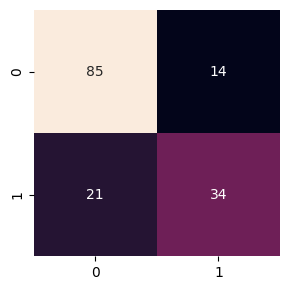

              precision    recall  f1-score   support

           0       0.80      0.86      0.83        99
           1       0.71      0.62      0.66        55

    accuracy                           0.77       154
   macro avg       0.76      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154



In [25]:

matriz_cm = confusion_matrix(y_test, test_pred_1)
cm_df = pd.DataFrame(matriz_cm)
plt.figure(figsize = (3, 3))
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False)
plt.tight_layout()
plt.show() 
print(classification_report(y_test, test_pred_1))

#### Podemos observar en la matriz del modelo seleccionado un 72% de accuracy lo que significa una capacidad notable, pero no tan fiable de predecir correctamente los casos de diabletes usando este modelo. Se podrai usar otro modelo o mejorar el que se esta usando.
#### En el caso de Diabletes negativa (0), el porcentaje de acierto es un poco mejor 77% ,teniendo en cuenta que el recall es de 80% ,detecta mejor los casos de falsos negativo. 

### Busqueda de hiperparamentros

In [26]:
#Busqueda extensiva
param_dist = {
    'n_estimators': randint(1, 20),
    'learning_rate': uniform(0.01, 0.9),
    'max_depth': randint(0, 20),
    'gamma': uniform(0, 5),
    'subsample': uniform(0, 1)
}

model = XGBClassifier(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=5,                 
    scoring='recall',
    cv=5,
    verbose=4,
    n_jobs=-1,
    random_state=123
)

random_search.fit(X_train_sel, y_train)

print("Mejores hiperparámetros:")
print(random_search.best_params_)

best_model = random_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END gamma=3.482345927989308, learning_rate=0.26752540145534154, max_depth=2, n_estimators=7, subsample=0.719150310154773;, score=0.381 total time=   0.0s
[CV 2/5] END gamma=3.482345927989308, learning_rate=0.26752540145534154, max_depth=2, n_estimators=7, subsample=0.719150310154773;, score=0.581 total time=   0.0s
[CV 3/5] END gamma=3.482345927989308, learning_rate=0.26752540145534154, max_depth=2, n_estimators=7, subsample=0.719150310154773;, score=0.628 total time=   0.0s
[CV 5/5] END gamma=3.482345927989308, learning_rate=0.26752540145534154, max_depth=2, n_estimators=7, subsample=0.719150310154773;, score=0.571 total time=   0.0s
[CV 4/5] END gamma=3.482345927989308, learning_rate=0.26752540145534154, max_depth=2, n_estimators=7, subsample=0.719150310154773;, score=0.465 total time=   0.0s
[CV 2/5] END gamma=2.4555946671629862, learning_rate=0.7120249857208713, max_depth=1, n_estimators=1, subsample=0.57969429702

In [27]:
param_dist_xgb = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5, 6, 8],
    "min_child_weight": [1, 3, 5, 7],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.5],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [0.5, 1, 1.5, 2]
}
# Definimos el clasificador
xgb = XGBClassifier(
    objective="binary:logistic",   
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=40,          
    scoring="f1",
    cv=5,
    n_jobs=--1,
    verbose=0,
    random_state=42
)

random_search_xgb.fit(X_train, y_train)


print(" Mejores hiperparámetros:", random_search_xgb.best_params_)
print(" Mejor f1_score:", random_search_xgb.best_score_)

/home/vscode/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:23:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:23:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:23:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:23:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.11/site-packages/xgboost/trainin

 Mejores hiperparámetros: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
 Mejor f1_score: 0.6570912741876598


/home/vscode/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:24:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:24:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [28]:
#Mejores hiperparámetros:
#{'gamma': np.float64(0.6998), 'learning_rate': np.float64(0.37091), 'max_depth': 0, 'n_estimators': 16, 'subsample': np.float64(0.324150)}

op_model_boosted_ = XGBClassifier(
    n_estimators=16,
    max_depth=0, 
    learning_rate=0.37091, 
    objective='binary:logistic',
    gamma=(0.6998),
    subsample=(0.324150),
    random_state=42
)
op_model_boosted_.fit(X_train_sel,y_train)
# make predictions 
test_pred = op_model_boosted_.predict(X_test_sel)
accuracy_score(y_test,test_pred)    

0.6948051948051948

### Con la busqueda de hiperparametros no se ven mejoras en los resultados , habria que ir probando más alternaivas diferentes en el ajuste de paramentros del modelo de boosting 

### Comparando los 3 modelos anteriores utilizados, RandomForest es el que mejor Accuracy,F1,Precision y Recall da de los tres, refleja el resultado mas óptimo de los hiperparamentros. 
